In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re
import json
from datetime import datetime
import pickle
import time
import seaborn as sns
import matplotlib.pyplot as plt

from scrape_tdf_data import *  # import helper functions

%matplotlib inline

### Load `year_links_num_dict`

In [2]:
year_links_num_dict = load_pickle('year_links_num_dict')

In [3]:
year_links_num_dict

{1903: {'mainurl': '/en/block/history/10707/d0ab6a216569236433268b7f19e1776c',
  'ranking_url': '/en/block/history/10707/ranking/c4eb59986a1ba20371a3df6c74ceb25b',
  'starters_url': '/en/block/history/10707/starters/df151b25da25a66cf629b8098211c08c',
  'the_race_url': '/en/block/history/10707/the_race/3679370d92b2c33c963ce44566d6da93',
  'stages_url': '/en/block/history/10707/stages/d2ee4f144d6a7ce9bcad5d7aada4b86d',
  'jersey_wearers_url': '/en/block/history/10707/jerseys/d92fd8558eb3e81c7e5d199a96c031eb',
  'stages_winners_url': '/en/block/history/10707/winners/fb20799446ca7516bcf7a9844bda488a',
  'num_of_stages': 6},
 1904: {'mainurl': '/en/block/history/10708/0b76b8f809ad5d8bcf3579df597644d8',
  'ranking_url': '/en/block/history/10708/ranking/357e5c608514340a1b3d2bff0fd396c7',
  'starters_url': '/en/block/history/10708/starters/7fcff3460678d7b275f79e468d02dd05',
  'the_race_url': '/en/block/history/10708/the_race/ddd82648a02bd8fcebda0a33f61b0d4a',
  'stages_url': '/en/block/history

## Building data visualizations

#### Plot number of stages over time

In [4]:
stages_df = load_pickle('stages_all')
print(stages_df.shape)
stages_df.head()

(2259, 5)


year stage_num date_start                start_city        finish_city
0  2018   Stage 1 2018-07-07      Noirmoutier-en-l'Île  Fontenay-le-Comte
1  2018   Stage 2 2018-08-07  Mouilleron-Saint-Germain   La Roche-sur-Yon
2  2018   Stage 3 2018-09-07                    Cholet             Cholet
3  2018   Stage 4 2018-10-07                  La Baule            Sarzeau
4  2018   Stage 5 2018-11-07                   Lorient            Quimper

In [5]:
num_stages_ea_year = pd.DataFrame(stages_df.groupby(['year']).size().reset_index())
num_stages_ea_year.columns = ['year','num_of_stages']
num_stages_ea_year.head()

year  num_of_stages
0  1903              6
1  1904              6
2  1905             11
3  1906             14
4  1907             14

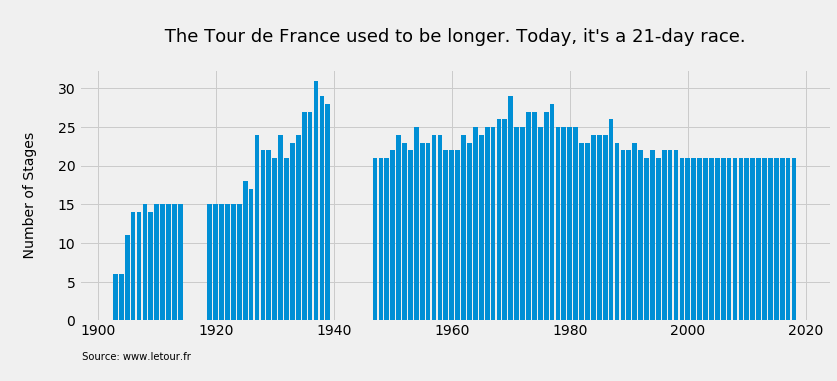

In [10]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.85, bottom=0.15)

data = num_stages_ea_year.copy()

ax.bar(data.year, data.num_of_stages)
ax.set_title("\n The Tour de France used to be longer. Today, it's a 21-day race. \n", size=18)
# plt.xlabel('\n ', size=14)
plt.ylabel('\n Number of Stages \n', size=14)
plt.annotate('\n Source: www.letour.fr \n', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/00_num_stages_over_time.png')

#### Top stage winners all time

In [11]:
stage_winners_df = load_pickle('stage_winners_all')
print(stage_winners_df.shape)
stage_winners_df.head()

(2196, 5)


year  stage_num                                     parcours  \
0  2018        1.0     Noirmoutier-en-l'Île > Fontenay-le-Comte   
1  2018        2.0  Mouilleron-Saint-Germain > La Roche-sur-Yon   
2  2018        4.0                           La Baule > Sarzeau   
3  2018        5.0                            Lorient > Quimper   
4  2018        6.0            Brest > Mûr-de-Bretagne Guerlédan   

                    winner                   team  
0  FERNANDO GAVIRIA RENDON  (QUICK - STEP FLOORS)  
1              PETER SAGAN     (BORA - HANSGROHE)  
2  FERNANDO GAVIRIA RENDON  (QUICK - STEP FLOORS)  
3              PETER SAGAN     (BORA - HANSGROHE)  
4            DANIEL MARTIN    (UAE TEAM EMIRATES)

How informative is the total number of stage winners over time?

In [12]:
stage_winners_df.groupby(['year','winner']).size().sort_values(ascending=False).head(10)

year  winner           
1970  EDDY MERCKX          8
1976  FREDDY MAERTENS      8
1930  CHARLES PELISSIER    8
1974  EDDY MERCKX          8
1979  BERNARD HINAULT      7
1948  GINO BARTALI         7
1969  EDDY MERCKX          6
1932  ANDRÉ LEDUCQ         6
1973  LUIS OCANA           6
1913  MARCEL BUYSSE        6
dtype: int64

#### Plotting yellow jerseys over time

In [13]:
jersey_wearers_df = load_pickle('jersey_wearers_all')
print(jersey_wearers_df.shape)
jersey_wearers_df.head()

(2259, 6)


year  stage_num            yellow_jersey        green_jersey  \
0  2018        1.0  FERNANDO GAVIRIA RENDON       MARCEL KITTEL   
1  2018        2.0              PETER SAGAN  ALEXANDER KRISTOFF   
2  2018        3.0        GREG VAN AVERMAET         PETER SAGAN   
3  2018        4.0        GREG VAN AVERMAET         PETER SAGAN   
4  2018        5.0        GREG VAN AVERMAET         PETER SAGAN   

  polka_dot_jersey             white_jersey  
0   KEVIN LEDANOIS        DYLAN GROENEWEGEN  
1       DION SMITH  FERNANDO GAVIRIA RENDON  
2       DION SMITH     SØREN KRAGH ANDERSEN  
3       DION SMITH     SØREN KRAGH ANDERSEN  
4     TOMS SKUJINS     SØREN KRAGH ANDERSEN

In [14]:
s = jersey_wearers_df.yellow_jersey.value_counts()
idx = s[s>5].index
yellow_5 = jersey_wearers_df[jersey_wearers_df.yellow_jersey.isin(idx)]
yellow_5.shape

(1738, 6)

In [15]:
yellows_over_time = pd.DataFrame(yellow_5.groupby(['yellow_jersey','year']).size().reset_index())
yellows_over_time.columns = ['rider','year','num_of_yellow_jerseys']
yellows_over_time.head()

rider  year  num_of_yellow_jerseys
0     ADELIN BENOIT  1925                      6
1  ALBERTO CONTADOR  2007                      4
2  ALBERTO CONTADOR  2009                      7
3      ALBERTO ELLI  2000                     16
4   ANDRÉ DARRIGADE  1956                      6

In [16]:
yellows_over_time['cum_yellows'] = yellows_over_time.groupby('rider')['num_of_yellow_jerseys'].apply(lambda x: x.cumsum())
yellows_over_time.head()

rider  year  num_of_yellow_jerseys  cum_yellows
0     ADELIN BENOIT  1925                      6            6
1  ALBERTO CONTADOR  2007                      4            4
2  ALBERTO CONTADOR  2009                      7           11
3      ALBERTO ELLI  2000                     16           16
4   ANDRÉ DARRIGADE  1956                      6            6

In [17]:
len(yellows_over_time.rider.unique())

105

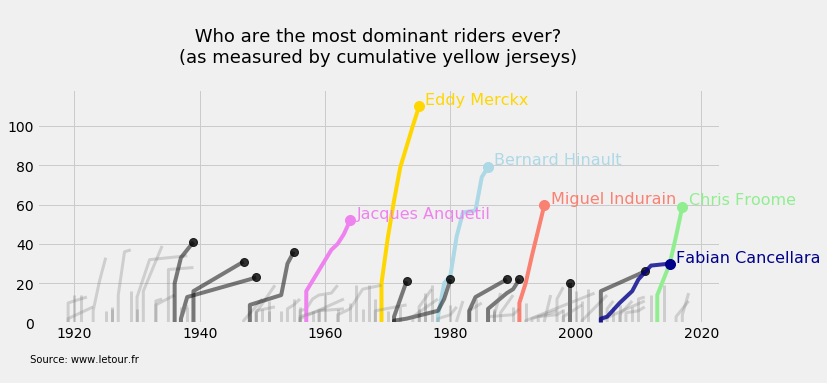

In [18]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8, bottom=0.15, right=0.87)

data = yellows_over_time.copy()

for rider in list(data.rider.unique()):
    d = data[data.rider == rider]
    first_row = pd.DataFrame([{'rider':None, 'year':None, 'cum_yellows':0}])
    d = pd.concat([first_row, d], sort=False).fillna(method='bfill')
    final_year = d.tail(1)

    if rider == 'EDDY MERCKX':
        ax.plot(d.year, d.cum_yellows, color='gold', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1,rider.title(), size=16, color='gold')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='gold')
    elif rider == 'BERNARD HINAULT':
        ax.plot(d.year, d.cum_yellows, color='lightblue', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1.5,rider.title(), size=16, color='lightblue')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='lightblue')
    elif rider == 'MIGUEL INDURAIN':
        ax.plot(d.year, d.cum_yellows, color='salmon', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1,rider.title(), size=16, color='salmon')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='salmon')
    elif rider == 'CHRIS FROOME':
        ax.plot(d.year, d.cum_yellows, color='lightgreen', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1.5,rider.title(), size=16, color='lightgreen')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='lightgreen')
    elif rider == 'JACQUES ANQUETIL':
        ax.plot(d.year, d.cum_yellows, color='violet', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1,rider.title(), size=16, color='violet')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='violet')
    elif rider == 'FABIAN CANCELLARA':
        ax.plot(d.year, d.cum_yellows, color='darkblue', alpha=0.8, zorder=10)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1,rider.title(), size=16, color='darkblue')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='darkblue')
    elif rider in ['LOUISON BOBET','RENÉ VIETTO','FABIAN CANCELLARA','THOMAS VOECKLER','GINO BARTALI','JOOP ZOETEMELK',
                   'GREG LEMOND','LAURENT FIGNON','LUIS OCANA','SYLVÈRE MAES','JAAN KIRSIPUU']:
        ax.plot(d.year, d.cum_yellows, color='black', alpha=0.5)
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=8, color='black', alpha=0.8)
    else:
        ax.plot(d.year, d.cum_yellows, color='grey', alpha=0.3, linewidth=3)
    
plt.title('\n Who are the most dominant riders ever? \n(as measured by cumulative yellow jerseys)\n', size=18)
plt.ylim(0,119)
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-10, -20), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/01_cumulative_yellow_jerseys_over_time.png')

In [128]:
yellows_over_time.groupby('rider')['cum_yellows'].max().sort_values(ascending=False).head(20)

rider
EDDY MERCKX           110
BERNARD HINAULT        79
MIGUEL INDURAIN        60
CHRIS FROOME           59
JACQUES ANQUETIL       52
SYLVÈRE MAES           41
ANTONIN MAGNE          39
NICOLAS FRANTZ         37
LOUISON BOBET          36
ANDRÉ LEDUCQ           34
OTTAVIO BOTTECCHIA     33
RENÉ VIETTO            31
FABIAN CANCELLARA      30
ROMAIN MAES            28
THOMAS VOECKLER        26
GINO BARTALI           23
LAURENT FIGNON         22
JOOP ZOETEMELK         22
GREG LEMOND            22
LUIS OCANA             21
Name: cum_yellows, dtype: int64

#### Top jersey wearers of all time

In [20]:
j = jersey_wearers_df.copy()
gb = j.groupby('year')
all_jersey_winners = gb.apply(lambda g: g[g['stage_num'] == g['stage_num'].max()])
all_jersey_winners = all_jersey_winners.reset_index(drop=True)
print(all_jersey_winners.shape)
all_jersey_winners.head()

(105, 6)


year  stage_num yellow_jersey green_jersey polka_dot_jersey white_jersey
0  1903        6.0           NaN          NaN              NaN          NaN
1  1904        6.0           NaN          NaN              NaN          NaN
2  1905       11.0           NaN          NaN              NaN          NaN
3  1906       13.2           NaN          NaN              NaN          NaN
4  1907       14.0           NaN          NaN              NaN          NaN

In [21]:
y = all_jersey_winners.groupby('yellow_jersey').size().sort_values(ascending=False).head(18)
g = all_jersey_winners.groupby('green_jersey').size().sort_values(ascending=False).head(18)
p = all_jersey_winners.groupby('polka_dot_jersey').size().sort_values(ascending=False).head(18)

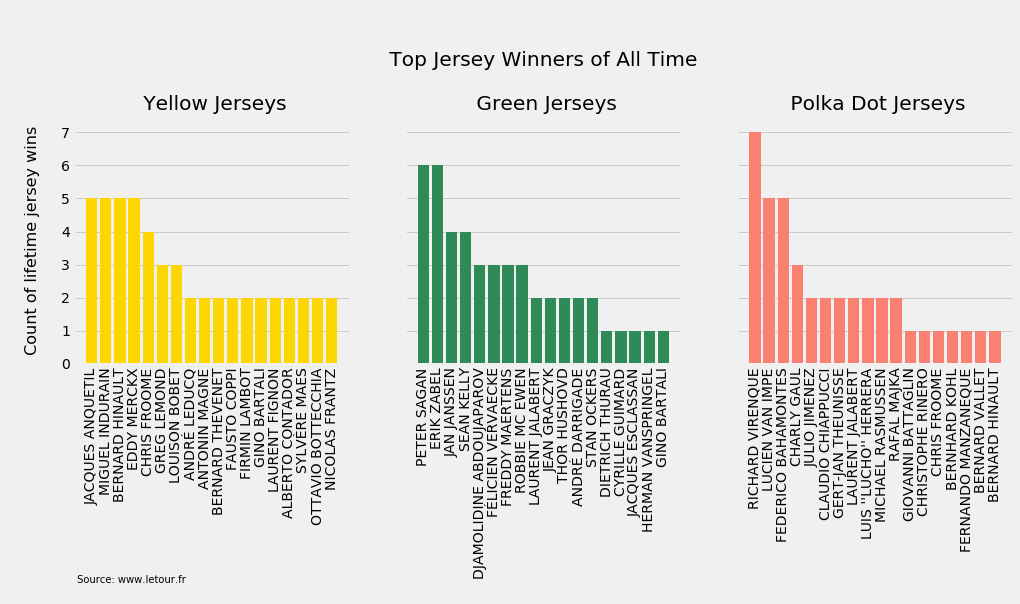

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,8))
plt.gcf().subplots_adjust(bottom=0.41, top=.84)

ax0 = axes[0]
ax0.bar(y.index, y.values, color='gold')
ax0.set_xticklabels(y.index, rotation=90)
ax0.set_ylim(0,7.5)
ax0.grid(b=False, axis='x')
ax0.set_ylabel('\n Count of lifetime jersey wins \n', size=16)
ax0.set_title('\n Yellow Jerseys')

ax1 = axes[1]
ax1.bar(g.index, g.values, color='seagreen')
ax1.set_xticklabels(g.index, rotation=90)
ax1.set_ylim(0,7.5)
ax1.grid(b=False, axis='x')
ax1.set_title('\n\n Top Jersey Winners of All Time \n\n Green Jerseys')
ax1.set_yticklabels(['','','','','','','',''])

ax2 = axes[2]
ax2.bar(p.index, p.values, color='salmon')
ax2.set_xticklabels(p.index, rotation=90)
ax2.set_ylim(0,7.5)
ax2.grid(b=False, axis='x')
ax2.set_title('\n Polka Dot Jerseys')
ax2.set_yticklabels(['','','','','','','',''])

ax0.annotate('\n Source: www.letour.fr \n', (0,0), (0, -200), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/13_lifetime_jersey_winners.png')

How many **simultaneous jersey winners** are there?

In [23]:
all_jersey_winners[all_jersey_winners.yellow_jersey == all_jersey_winners.green_jersey] # none

Empty DataFrame
Columns: [year, stage_num, yellow_jersey, green_jersey, polka_dot_jersey, white_jersey]
Index: []

In [24]:
all_jersey_winners[all_jersey_winners.yellow_jersey == all_jersey_winners.white_jersey] # 1

year  stage_num yellow_jersey         green_jersey  polka_dot_jersey  \
96  2010       20.0  ANDY SCHLECK  ALESSANDRO PETACCHI  ANTHONY CHARTEAU   

    white_jersey  
96  ANDY SCHLECK

In [25]:
all_jersey_winners[all_jersey_winners.yellow_jersey == all_jersey_winners.polka_dot_jersey] # 2

year  stage_num     yellow_jersey green_jersey  polka_dot_jersey  \
89   2003       20.0  RICHARD VIRENQUE  BADEN COOKE  RICHARD VIRENQUE   
101  2015       21.0      CHRIS FROOME  PETER SAGAN      CHRIS FROOME   

       white_jersey  
89    DENIS MENCHOV  
101  NAIRO QUINTANA

In [26]:
all_jersey_winners[all_jersey_winners.polka_dot_jersey == all_jersey_winners.white_jersey] # 1

year  stage_num yellow_jersey green_jersey polka_dot_jersey  \
99  2013       21.0  CHRIS FROOME  PETER SAGAN   NAIRO QUINTANA   

      white_jersey  
99  NAIRO QUINTANA

First year there was a **yellow jersey**

In [27]:
all_jersey_winners.iloc[all_jersey_winners.yellow_jersey.first_valid_index()]

year                         1919
stage_num                      15
yellow_jersey       FIRMIN LAMBOT
green_jersey                  NaN
polka_dot_jersey              NaN
white_jersey                  NaN
Name: 12, dtype: object

First year there was a **green jersey**

In [28]:
all_jersey_winners.iloc[all_jersey_winners.green_jersey.first_valid_index()]

year                            1933
stage_num                         23
yellow_jersey       GEORGES SPEICHER
green_jersey          VICENTE TRUEBA
polka_dot_jersey                 NaN
white_jersey                     NaN
Name: 26, dtype: object

First **polka dot jersey**

In [29]:
all_jersey_winners.iloc[all_jersey_winners.polka_dot_jersey.first_valid_index()]

year                         1953
stage_num                      22
yellow_jersey       LOUISON BOBET
green_jersey         FRITZ SCHAER
polka_dot_jersey     JÉSUS LORONO
white_jersey                  NaN
Name: 39, dtype: object

First **white** jersey

In [30]:
all_jersey_winners.iloc[all_jersey_winners.white_jersey.first_valid_index()]

year                             1977
stage_num                        22.2
yellow_jersey        BERNARD THEVENET
green_jersey        JACQUES ESCLASSAN
polka_dot_jersey      LUCIEN VAN IMPE
white_jersey          DIETRICH THURAU
Name: 63, dtype: object

#### Bump chart for 2018 race

In [31]:
rankings_2018 = pd.read_csv('data/2018/2018_rankings_itg.csv')
rankings_2018 = rankings_2018.rename(columns={'rank':'ranking'})
print(rankings_2018.shape)
rankings_2018.head()

(3351, 9)


stage_num  ranking                    rider  rider_no  \
0          1        1  FERNANDO GAVIRIA RENDON       103   
1          1        2              PETER SAGAN       111   
2          1        3            MARCEL KITTEL       144   
3          1        4            OLIVER NAESEN        27   
4          1        5       ALEXANDER KRISTOFF        95   

                   team         times             gap    b    p  
0   QUICK - STEP FLOORS  04h 23' 22''               -  10'  NaN  
1      BORA - HANSGROHE  04h 23' 26''  + 00h 00' 04''  06'  NaN  
2  TEAM KATUSHA ALPECIN  04h 23' 28''  + 00h 00' 06''  04'  NaN  
3      AG2R LA MONDIALE  04h 23' 31''  + 00h 00' 09''  01'  NaN  
4     UAE TEAM EMIRATES  04h 23' 32''  + 00h 00' 10''  NaN  NaN

In [32]:
len(list(data.rider.unique()))  # 81 riders in 176

105

In [132]:
rankings_2018

stage_num  ranking                      rider  rider_no  \
0             1        1    FERNANDO GAVIRIA RENDON       103   
1             1        2                PETER SAGAN       111   
2             1        3              MARCEL KITTEL       144   
3             1        4              OLIVER NAESEN        27   
4             1        5         ALEXANDER KRISTOFF        95   
5             1        6         CHRISTOPHE LAPORTE       201   
6             1        7          DYLAN GROENEWEGEN       163   
7             1        8           MICHAEL MATTHEWS        31   
8             1        9             JOHN DEGENKOLB       194   
9             1       10             JAKOB FUGLSANG       121   
10            1       11                RAFAL MAJKA       114   
11            1       12            VINCENZO NIBALI        51   
12            1       13             TIMOTHY DUPONT       213   
13            1       14              THOMAS BOUDAT       182   
14            1       15             GERAINT THOMAS         8   
15            1       16                BOB JUNGELS       105   
16            1       17            MICHAEL VALGREN       128   
17            1       18  MAXIMILIANO ARIEL RICHEZE       107   
18            1       19           PHILIPPE GILBERT       104   
19            1       20       EDVALD BOASSON HAGEN       132   
20            1       21            SONNY COLBRELLI        52   
21            1       22             JASPER STUYVEN       198   
22            1       23           ANDREA PASQUALON       216   
23            1       24         JULIAN ALAPHILIPPE       101   
24            1       25          GREG VAN AVERMAET        87   
25            1       26            DMITRIY GRUZDEV       123   
26            1       27              ANDRÉ GREIPEL       171   
27            1       28               TOM DUMOULIN        32   
28            1       29             WARREN BARGUIL        41   
29            1       30               TIESJ BENOOT       172   
...         ...      ...                        ...       ...   
3321         21      116             ANTHONY TURGIS       208   
3322         21      117            MICHAEL HEPBURN        65   
3323         21      118             LUKE DURBRIDGE        63   
3324         21      119              NIKI TERPSTRA       108   
3325         21      120            FABIEN GRELLIER       186   
3326         21      121                 JACK BAUER        62   
3327         21      122              MACIEJ BODNAR       112   
3328         21      123   GUILLAUME VAN KEIRSBULCK       218   
3329         21      124         CHRISTOPHE LAPORTE       201   
3330         21      125          HEINRICH HAUSSLER        53   
3331         21      126              MARCO MARCATO        96   
3332         21      127             OLIVIER LE GAC       154   
3333         21      128                  LUKE ROWE         7   
3334         21      129                 TOM SCULLY        17   
3335         21      130             DIMITRI CLAEYS       202   
3336         21      131             TIMOTHY DUPONT       213   
3337         21      132          LUKAS PÖSTLBERGER       118   
3338         21      133             OLIVIERO TROIA        98   
3339         21      134            RAMON SINKELDAM       157   
3340         21      135  MAXIMILIANO ARIEL RICHEZE       107   
3341         21      136             TAYLOR PHINNEY        15   
3342         21      137                TIMO ROOSEN       167   
3343         21      138            ROBERTO FERRARI        94   
3344         21      139      AMUND GRØNDAHL JANSEN       164   
3345         21      140              DAMIEN GAUDIN       185   
3346         21      141              ARNAUD DEMARE       151   
3347         21      142            JASPER DE BUYST       173   
3348         21      143         JAY ROBERT THOMSON       137   
3349         21      144           JACOPO GUARNIERI       153   
3350         21      145            LAWSO

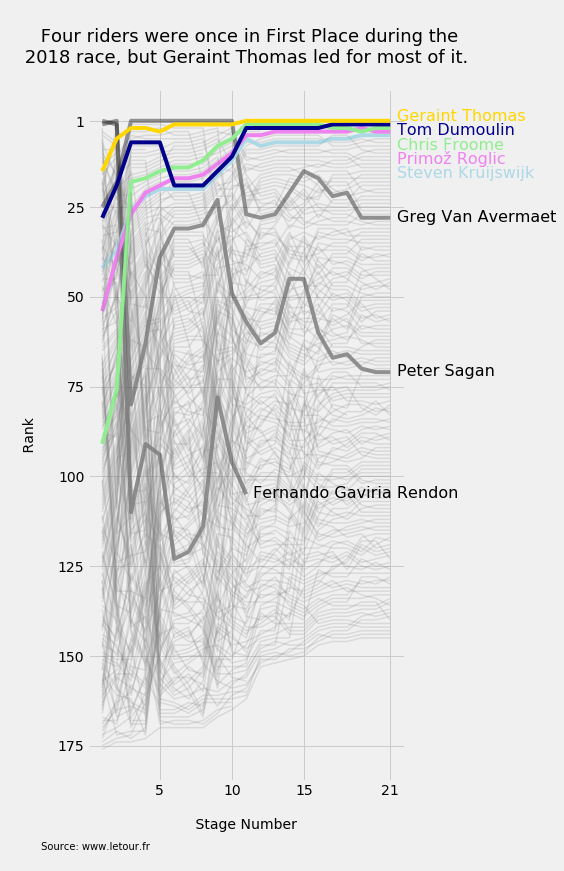

In [33]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.9, bottom=0.10, left=0.15, right=0.70)

data = rankings_2018.copy()

for rider in list(data.rider.unique()):
    d = data[data.rider == rider]
    d = d[['stage_num','ranking']]
    
    if rider == 'GERAINT THOMAS':
        ax.plot(d.stage_num, d.ranking, color='gold', alpha=1.0, zorder=10)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1),rider.title(), size=16, color='gold')
    elif rider == 'TOM DUMOULIN':
        ax.plot(d.stage_num, d.ranking, color='darkblue', alpha=1.0, zorder=9)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+3,rider.title(), size=16, color='darkblue')
    elif rider == 'CHRIS FROOME':
        ax.plot(d.stage_num, d.ranking, color='lightgreen', alpha=1.0)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+6,rider.title(), size=16, color='lightgreen')
    elif rider == 'PRIMOŽ ROGLIC':
        ax.plot(d.stage_num, d.ranking, color='violet', alpha=1.0)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+9,rider.title(), size=16, color='violet')
    elif rider == 'STEVEN KRUIJSWIJK':
        ax.plot(d.stage_num, d.ranking, color='lightblue', alpha=1.0)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+12,rider.title(), size=16, color='lightblue')
    elif rider in ['GREG VAN AVERMAET', 'PETER SAGAN', 'FERNANDO GAVIRIA RENDON']:
        ax.plot(d.stage_num, d.ranking, color='black', alpha=0.4)
        plt.text(d.stage_num.tail(1)+0.5, d.ranking.tail(1)+1,rider.title(), size=16, color='black')        
    else:
        ax.plot(d.stage_num, d.ranking, color='grey', alpha=0.2, linewidth=1.5)
    
plt.gca().invert_yaxis()
ax.set_title('\n Four riders were once in First Place during the\n 2018 race, but Geraint Thomas led for most of it. \n', size=18)
ax.set_ylabel('\n Rank \n', size=14)
ax.set_xlabel('\n Stage Number \n', size=14)
ax.set_xticks([5,10,15,21])
ax.set_yticks([1,25,50,75,100,125,150,175])
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-50, -50), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/02_rankings_2018.png')

### Bump chart for the first TDF race in 1997

In [34]:
rankings_1997 = pd.read_csv('data/1997/1997_rankings_itg.csv')
rankings_1997 = rankings_1997.rename(columns={'rank':'ranking'})
rankings_1997#.head()

stage_num  ranking                rider  rider_no  \
0             1        1      MARIO CIPOLLINI       114   
1             1        2       CHRIS BOARDMAN        91   
2             1        3          JAN ULLRICH         8   
3             1        4        TONY ROMINGER        61   
4             1        5        ABRAHAM OLANO       151   
5             1        6           TOM STEELS        27   
6             1        7       SERVAIS KNAVEN       105   
7             1        8          ERIK DEKKER       124   
8             1        9      OSCAR CAMENZIND        22   
9             1       10  FRANK VANDENBROUCKE        29   
10            1       11     LAURENT JALABERT        31   
11            1       12         JENS HEPPNER         5   
12            1       13       FRANKIE ANDREU        62   
13            1       14   FRÉDÉRIC MONCASSIN        92   
14            1       15    JEROEN BLIJLEVENS       102   
15            1       16     ARTURAS KASPUTIS       137   
16            1       17        ADRIANO BAFFI       192   
17            1       18       DANNY NELISSEN       127   
18            1       19          PASCAL LINO       211   
19            1       20           ERIK ZABEL         9   
20            1       21   MAARTEN DEN BAKKER       101   
21            1       22     DANIELE NARDELLO        25   
22            1       23      GEORGE HINCAPIE       196   
23            1       24   PETER LÜTTENBERGER       121   
24            1       25       MATTEO TOSATTO        49   
25            1       26      DAVIDE REBELLIN        77   
26            1       27        JON ODRIOZOLA       147   
27            1       28          ANDREA TAFI        28   
28            1       29        MARCO FINCATO        83   
29            1       30         LUCA COLOMBO       144   
...         ...      ...                  ...       ...   
3530         21      110          NICOLA LODA        46   
3531         21      111     FRÉDÉRIC GUESDON        72   
3532         21      112     BRUNO CENGHIALTA       143   
3533         21      113   SERGUEI OUTSCHAKOV        58   
3534         21      114   FRÉDÉRIC MONCASSIN        92   
3535         21      115    CHRISTOPHE RINERO        68   
3536         21      116      GILBERTO SIMONI        48   
3537         21      117       ROBBIE MC EWEN       126   
3538         21      118    GIOVANNI LOMBARDI         6   
3539         21      119        ADRIANO BAFFI       192   
3540         21      120          LUCA SCINTO        47   
3541         21      121     MARCELINO GARCIA        34   
3542         21      122        NICOLA MINALI       146   
3543         21      123       MIRCO CREPALDI        54   
3544         21      124            LAURI AUS       133   
3545         21      125      GERRIT DE VRIES        55   
3546         21      126    JEROEN BLIJLEVENS       102   
3547         21      127     LAURENT DESBIENS        63   
3548         21      128      TRISTAN HOFFMAN       104   
3549         21      129          CARLO FINCO        43   
3550         21      130        ROSSANO BRASI        52   
3551         21      131        PASCAL DERAME       194   
3552         21      132       MATTEO TOSATTO        49   
3553         21      133    GIANLUCA PIEROBON       148   
3554         21      134            EROS POLI        94   
3555         21      135     NICOLAS JALABERT        65   
3556         21      136      TORSTEN SCHMIDT        86   
3557         21      137      PHILIPP BUSCHOR       112   
3558         21      138       STÉPHANE CUEFF       203   
3559         21      139     PHILIPPE GAUMONT        64   

                               team         times             gap   b   p  
0                       SAECO-ESTRO  04h 48' 09''               - NaN NaN  
1                               GAN  04h 48' 19''  + 00h 00' 10'' NaN NaN  
2             TEAM DEUTSCHE TELEKOM  04h 48' 21''  + 00h 00' 12'' NaN NaN  
3                           COFIDIS  04h 48

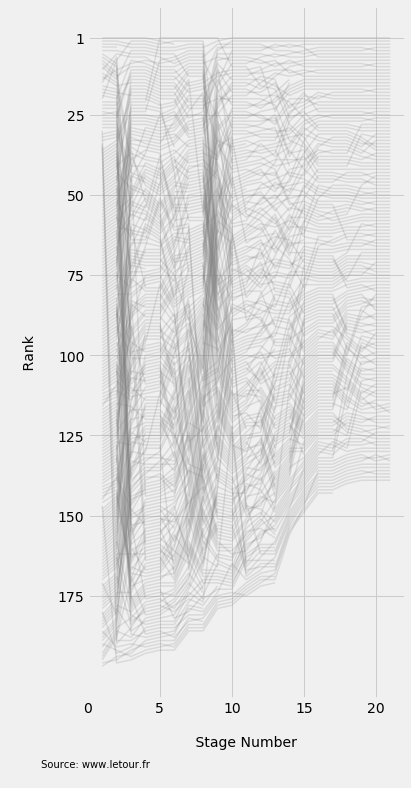

In [35]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.9, bottom=0.10, left=0.15, right=0.70)

data = rankings_1997.copy()

for rider in list(data.rider.unique()):
    d = data[data.rider == rider]
    d = d[['stage_num','ranking']]
#     d.columns = ['stage_num','ranking']
    
#     if rider == 'GERAINT THOMAS':
#         ax.plot(d.stage_num, d.ranking, color='gold', alpha=1.0, zorder=10)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1),rider.title(), size=16, color='gold')
#     elif rider == 'TOM DUMOULIN':
#         ax.plot(d.stage_num, d.ranking, color='darkblue', alpha=1.0, zorder=9)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+3,rider.title(), size=16, color='darkblue')
#     elif rider == 'CHRIS FROOME':
#         ax.plot(d.stage_num, d.ranking, color='lightgreen', alpha=1.0)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+6,rider.title(), size=16, color='lightgreen')
#     elif rider == 'PRIMOŽ ROGLIC':
#         ax.plot(d.stage_num, d.ranking, color='violet', alpha=1.0)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+9,rider.title(), size=16, color='violet')
#     elif rider == 'STEVEN KRUIJSWIJK':
#         ax.plot(d.stage_num, d.ranking, color='lightblue', alpha=1.0)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+12,rider.title(), size=16, color='lightblue')
#     elif rider in ['GREG VAN AVERMAET', 'PETER SAGAN', 'FERNANDO GAVIRIA RENDON']:
#     ax.plot(d.stage_num, d.ranking, color='black', alpha=0.4)
#     plt.text(d.stage_num.tail(1)+0.5, d.ranking.tail(1)+1,rider.title(), size=16, color='black')        
#     else:
    ax.plot(d.stage_num, d.ranking, color='grey', alpha=0.2, linewidth=1.5)
    
plt.gca().invert_yaxis()
# ax.set_title('\n Four riders were once in First Place during the\n 2018 race, but Geraint Thomas led for most of it. \n', size=18)
ax.set_ylabel('\n Rank \n', size=14)
ax.set_xlabel('\n Stage Number \n', size=14)
# ax.set_xticks([5,10,15,21])
ax.set_yticks([1,25,50,75,100,125,150,175])
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-50, -50), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/03_rankings_1997.png')

## Explore merging in country names

In [2]:
starters_df = load_pickle('starters_all')
print(starters_df.shape)
starters_df.head()

(15001, 5)


year      team  rider_num               rider_name nationality
0  2018  TEAM SKY          1             CHRIS FROOME         gbr
1  2018  TEAM SKY          2  EGAN ARLEY BERNAL GOMEZ         col
2  2018  TEAM SKY          3     JONATHAN CASTROVIEJO         esp
3  2018  TEAM SKY          4       MICHAL KWIATKOWSKI         pol
4  2018  TEAM SKY          5            GIANNI MOSCON         ita

In [3]:
starters_df.groupby('year').size()

year
1903     84
1904     88
1905     60
1906     78
1907     93
1908    111
1909    150
1910    110
1911     84
1912    131
1913    140
1914    145
1919     67
1920    113
1921    123
1922    120
1923    139
1924    158
1925    129
1926    126
1927    142
1928    162
1929    155
1930    100
1931     81
1932     80
1933     80
1934     60
1935     93
1936     90
       ... 
1989    198
1990    198
1991    198
1992    198
1993    180
1994    189
1995    189
1996    198
1997    198
1998    189
1999    180
2000    180
2001    189
2002    189
2003    198
2004    188
2005    189
2006    176
2007    189
2008    180
2009    180
2010    198
2011    198
2012    198
2013    198
2014    198
2015    198
2016    198
2017    198
2018    176
Length: 105, dtype: int64

Pull in country names and IOC country codes from `countries_ioc_codes.csv`

In [4]:
ioc = pd.read_csv('data/country_ioc_codes.csv')
ioc.ioc_code = ioc.ioc_code.str.lower()
ioc.country = ioc.country.str.lower()
print(ioc.shape)
ioc.tail()

(208, 2)


ioc_code                           country
203      vin  saint vincent and the grenadines
204      yem                             yemen
205      yug                        yugoslavia
206      zam                            zambia
207      zim                          zimbabwe

Pull in continents info from `continents_country.csv`

In [5]:
continents = pd.read_csv('data/continent_country.csv')
continents.country = continents.country.str.lower()
countries = pd.merge(ioc, continents, how='left', on='country')
countries.head()

ioc_code      country continent
0      afg  afghanistan      asia
1      alb      albania    europe
2      alg      algeria    africa
3      and      andorra    europe
4      ang       angola    africa

In [6]:
merged_df = pd.merge(starters_df, countries, how='left', left_on='nationality',right_on='ioc_code')

List of country codes that **_couldn't_** be matched

In [7]:
merged_df[merged_df.country.isnull()]  # looks good!

Empty DataFrame
Columns: [year, team, rider_num, rider_name, nationality, ioc_code, country, continent]
Index: []

List of country codes that **_did match_**

In [8]:
merged_df[merged_df.country.isnull() == False].shape  # looks good!

(15001, 8)

#### Plot top nationality of riders over the entire time period

In [9]:
m = merged_df.copy()
m.head()

year      team  rider_num               rider_name nationality ioc_code  \
0  2018  TEAM SKY          1             CHRIS FROOME         gbr      gbr   
1  2018  TEAM SKY          2  EGAN ARLEY BERNAL GOMEZ         col      col   
2  2018  TEAM SKY          3     JONATHAN CASTROVIEJO         esp      esp   
3  2018  TEAM SKY          4       MICHAL KWIATKOWSKI         pol      pol   
4  2018  TEAM SKY          5            GIANNI MOSCON         ita      ita   

         country      continent  
0  great britain         europe  
1       colombia  south america  
2          spain         europe  
3         poland         europe  
4          italy         europe

In [10]:
all_riders = m.groupby(['rider_name','country']).size().reset_index()
all_riders.columns = ['rider_name','country','times_raced_in_tdf']
all_riders.sort_values('times_raced_in_tdf', ascending=False).head()

rider_name        country  times_raced_in_tdf
4804  SYLVAIN CHAVANEL         france                  18
1816   GEORGE HINCAPIE  united states                  17
4788    STUART O'GRADY      australia                  17
2650        JENS VOIGT        germany                  17
2728    JOOP ZOETEMELK    netherlands                  16

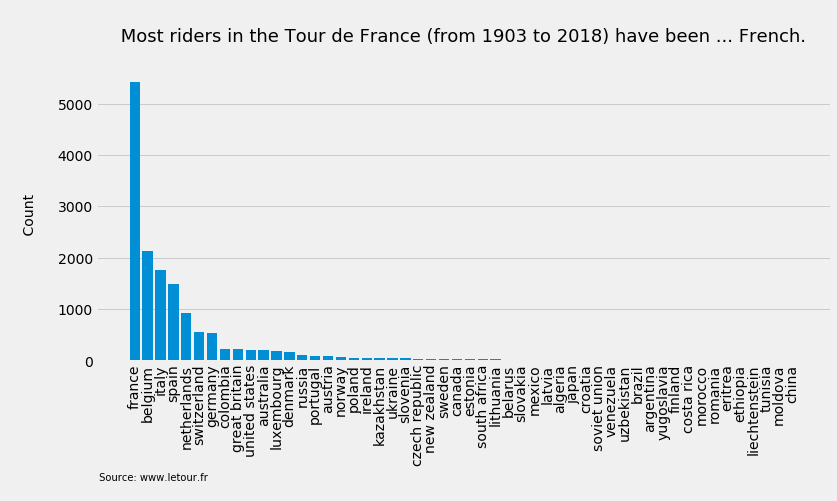

In [11]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
# plt.gcf().subplots_adjust(top=0.8, bottom=0.4, left=0.1)

data = m.country.value_counts(ascending=False)
    
ax.bar(data.index, data.values)
ax.set_title("\n Most riders in the Tour de France (from 1903 to 2018) have been ... French. \n", size=18)
# France, unsurprisingly, has produced the most riders in the Tour de France...
ax.set_xticklabels(data.index, rotation=90)
plt.ylabel('\n Count \n', size=14)
ax.grid(b=False, axis='x')
plt.annotate('\n Source: www.letour.fr \n', (0,0), (0, -100), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.subplots_adjust(bottom=0.3, left=0.1)
plt.savefig(os.getcwd() + '/img/04_nationalities_of_riders.png')

#### Make a percentage stacked area chart

In [12]:
yr_nat_pct = m.groupby(['year','country','ioc_code']).size().reset_index()
yr_nat_pct.columns = ['year','country','ioc_code','num_of_riders']
yr_nat_pct.head()

year      country ioc_code  num_of_riders
0  1903      belgium      bel              4
1  1903       france      fra             73
2  1903      germany      ger              2
3  1903        italy      ita              1
4  1903  switzerland      sui              4

In [13]:
yr_num_of_riders = m.groupby('year').size().reset_index()
yr_num_of_riders.columns = ['year','yearly_total_num_riders']
yr_num_of_riders.head()

year  yearly_total_num_riders
0  1903                       84
1  1904                       88
2  1905                       60
3  1906                       78
4  1907                       93

In [14]:
yr_nat_pct = pd.merge(yr_nat_pct, yr_num_of_riders, how='left',on='year')

In [15]:
print(yr_nat_pct.shape)
yr_nat_pct.head(10)

(1494, 5)


year      country ioc_code  num_of_riders  yearly_total_num_riders
0  1903      belgium      bel              4                       84
1  1903       france      fra             73                       84
2  1903      germany      ger              2                       84
3  1903        italy      ita              1                       84
4  1903  switzerland      sui              4                       84
5  1904      belgium      bel             13                       88
6  1904       france      fra             69                       88
7  1904      germany      ger              1                       88
8  1904        italy      ita              2                       88
9  1904  switzerland      sui              3                       88

In [16]:
yr_nat_pct['nat_pct'] = yr_nat_pct.num_of_riders / yr_nat_pct.yearly_total_num_riders
yr_nat_pct.head()

year      country ioc_code  num_of_riders  yearly_total_num_riders  \
0  1903      belgium      bel              4                       84   
1  1903       france      fra             73                       84   
2  1903      germany      ger              2                       84   
3  1903        italy      ita              1                       84   
4  1903  switzerland      sui              4                       84   

    nat_pct  
0  0.047619  
1  0.869048  
2  0.023810  
3  0.011905  
4  0.047619

Create a base dataframe with all years between 1903 and 2019

In [17]:
all_years = pd.DataFrame(list(range(1903,2019)))
all_years.columns = ['year']
all_years.shape

(116, 1)

In [18]:
all_years_nat_pct = pd.merge(all_years, yr_nat_pct, how='left',on='year')
print(all_years_nat_pct.shape)
all_years_nat_pct.head(3)

(1505, 6)


year  country ioc_code  num_of_riders  yearly_total_num_riders   nat_pct
0  1903  belgium      bel            4.0                     84.0  0.047619
1  1903   france      fra           73.0                     84.0  0.869048
2  1903  germany      ger            2.0                     84.0  0.023810

In [53]:
pivoted_df = all_years_nat_pct.pivot(index='year', columns='country', values='nat_pct').T
pivoted_df.head()

year       1903  1904  1905  1906  1907  1908  1909  1910  1911  1912  ...  \
country                                                                ...   
NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
algeria     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
argentina   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
australia   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
austria     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

year           2009      2010      2011      2012      2013      2014  \
country                                                                 
NaN             NaN       NaN       NaN       NaN       NaN       NaN   
algeria         NaN       NaN       NaN       NaN       NaN       NaN   
argentina       NaN       NaN       NaN  0.005051       NaN  0.005051   
australia  0.038889  0.055556  0.030303  0.060606  0.055556  0.050505   
austria    0.011111  0.015152  0.005051  0.005051       NaN  0.005051   

year           2015      2016      2017      2018  
country                                            
NaN             NaN       NaN       NaN       NaN  
algeria         NaN       NaN       NaN       NaN  
argentina  0.005051  0.010101  0.005051  0.005682  
australia  0.050505  0.045455  0.045455  0.062500  
austria    0.015152  0.020202  0.015152  0.017045  

[5 rows x 116 columns]

In [54]:
labels_dict = {}
co_list = ['france', 'belgium', 'netherlands', 'italy', 'spain', 'germany',
           'australia', 'colombia', 'great britain', 'united states', 'switzerland']
color_list = ['darkblue','gold','darkorange','seagreen','firebrick','black',
              'darkgreen','salmon', 'grey','royalblue','red']

i = 0
ycoord_running_sum = 0
for country in co_list:
    data_pt = str(round(100 * pivoted_df.loc[country].tail(1).values[0], 1)) + '%'
    label = data_pt + '  ' + country.title()
    pct_in_2018 = pivoted_df.loc[country].tail(1).values[0]
    labels_dict[country] = {'label':label, 'color':color_list[i], 'ycoord':ycoord_running_sum + pct_in_2018/2 + 0.01}
    ycoord_running_sum = ycoord_running_sum + pct_in_2018
    
    i += 1
    
labels_dict

{'france': {'label': '19.9%  France',
  'color': 'darkblue',
  'ycoord': 0.10943181818181817},
 'belgium': {'label': '10.8%  Belgium',
  'color': 'gold',
  'ycoord': 0.26284090909090907},
 'netherlands': {'label': '8.0%  Netherlands',
  'color': 'darkorange',
  'ycoord': 0.3565909090909091},
 'italy': {'label': '7.4%  Italy',
  'color': 'seagreen',
  'ycoord': 0.43329545454545454},
 'spain': {'label': '7.4%  Spain',
  'color': 'firebrick',
  'ycoord': 0.5071590909090908},
 'germany': {'label': '6.2%  Germany',
  'color': 'black',
  'ycoord': 0.5753409090909091},
 'australia': {'label': '6.2%  Australia',
  'color': 'darkgreen',
  'ycoord': 0.6378409090909091},
 'colombia': {'label': '3.4%  Colombia',
  'color': 'salmon',
  'ycoord': 0.6861363636363637},
 'great britain': {'label': '2.8%  Great Britain',
  'color': 'grey',
  'ycoord': 0.7173863636363635},
 'united states': {'label': '2.8%  United States',
  'color': 'royalblue',
  'ycoord': 0.7457954545454545},
 'switzerland': {'label':

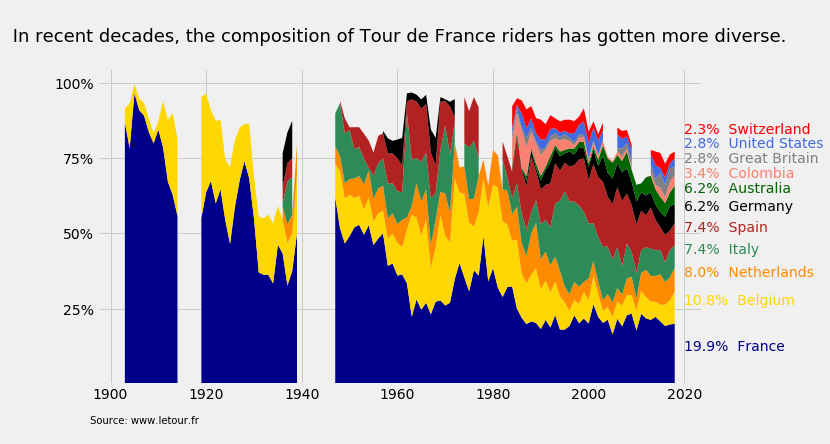

In [55]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, left=0.15, right=0.85)

years = np.array(pivoted_df.columns)
countries = np.array(pivoted_df.loc[co_list].sort_values(2018, ascending=False))

j = 0
for country, info in labels_dict.items():
    if country in ['great britain','united states','switzerland']:
        j += 1
        ax.text(2020, info['ycoord'] + (0.02*j), info['label'], color=info['color'])
    else:
        ax.text(2020, info['ycoord'], info['label'], color=info['color'])

plt.stackplot(years, countries, colors=color_list, labels=labels_dict)
ax.set_yticks([.25,.5,.75,1])
ax.set_yticklabels(['25%','50%','75%','100%'])
ax.set_title('\n In recent decades, the composition of Tour de France riders has gotten more diverse. \n ', size=18)
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-10, -20), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/07_nationality_mixture_over_time.png')
plt.show()

In the beginning, riders largely came from France and Beglium (until the late 1930s). Interesting how German riders don't return to the race until the late 1950s (took a decade to recover after WWII).

#### Make a country line chart instead of a stacked area chart

In [56]:
yr_nat_cnt = m.groupby(['year','country','ioc_code']).size().reset_index()
yr_nat_cnt.columns = ['year','country','ioc_code','num_of_riders']
# all_years = pd.DataFrame({'year':list(range(1903,2019))})  # merge in null years to get WWI/WWII gap
# yr_nat_cnt = pd.merge(all_years, yr_nat_cnt, how='left', on='year')
print(yr_nat_cnt.shape)
yr_nat_cnt.head()

(1494, 4)


year      country ioc_code  num_of_riders
0  1903      belgium      bel              4
1  1903       france      fra             73
2  1903      germany      ger              2
3  1903        italy      ita              1
4  1903  switzerland      sui              4

In [57]:
pivoted_df = yr_nat_cnt.pivot(index='year', columns='country', values='num_of_riders')#.T
pivoted_df.head()

country  algeria  argentina  australia  austria  belarus  belgium  brazil  \
year                                                                        
1903         NaN        NaN        NaN      NaN      NaN      4.0     NaN   
1904         NaN        NaN        NaN      NaN      NaN     13.0     NaN   
1905         NaN        NaN        NaN      NaN      NaN      2.0     NaN   
1906         NaN        NaN        NaN      NaN      NaN      3.0     NaN   
1907         NaN        NaN        NaN      NaN      NaN      4.0     NaN   

country  canada  china  colombia  ...  soviet union  spain  sweden  \
year                              ...                                
1903        NaN    NaN       NaN  ...           NaN    NaN     NaN   
1904        NaN    NaN       NaN  ...           NaN    NaN     NaN   
1905        NaN    NaN       NaN  ...           NaN    NaN     NaN   
1906        NaN    NaN       NaN  ...           NaN    NaN     NaN   
1907        NaN    NaN       NaN  ...           NaN    NaN     NaN   

country  switzerland  tunisia  ukraine  united states  uzbekistan  venezuela  \
year                                                                           
1903             4.0      NaN      NaN            NaN         NaN        NaN   
1904             3.0      NaN      NaN            NaN         NaN        NaN   
1905             NaN      NaN      NaN            NaN         NaN        NaN   
1906             NaN      NaN      NaN            NaN         NaN        NaN   
1907             2.0      NaN      NaN            NaN         NaN        NaN   

country  yugoslavia  
year                 
1903            NaN  
1904            NaN  
1905            NaN  
1906            NaN  
1907            NaN  

[5 rows x 52 columns]

In [58]:
list(pivoted_df.columns)

pivoted_df['france']#values
# pivoted_df['france'].index

year
1903     73.0
1904     69.0
1905     58.0
1906     71.0
1907     83.0
1908     93.0
1909    120.0
1910     93.0
1911     66.0
1912     88.0
1913     88.0
1914     81.0
1919     37.0
1920     72.0
1921     83.0
1922     72.0
1923     90.0
1924     86.0
1925     60.0
1926     74.0
1927     96.0
1928    120.0
1929    106.0
1930     55.0
1931     30.0
1932     29.0
1933     29.0
1934     20.0
1935     43.0
1936     39.0
        ...  
1989     40.0
1990     36.0
1991     42.0
1992     37.0
1993     41.0
1994     34.0
1995     34.0
1996     38.0
1997     45.0
1998     38.0
1999     39.0
2000     36.0
2001     50.0
2002     42.0
2003     40.0
2004     40.0
2005     31.0
2006     38.0
2007     36.0
2008     41.0
2009     42.0
2010     35.0
2011     46.0
2012     43.0
2013     42.0
2014     44.0
2015     41.0
2016     38.0
2017     39.0
2018     35.0
Name: france, Length: 105, dtype: float64

In [59]:
yr_nat_cnt.head()

year      country ioc_code  num_of_riders
0  1903      belgium      bel              4
1  1903       france      fra             73
2  1903      germany      ger              2
3  1903        italy      ita              1
4  1903  switzerland      sui              4

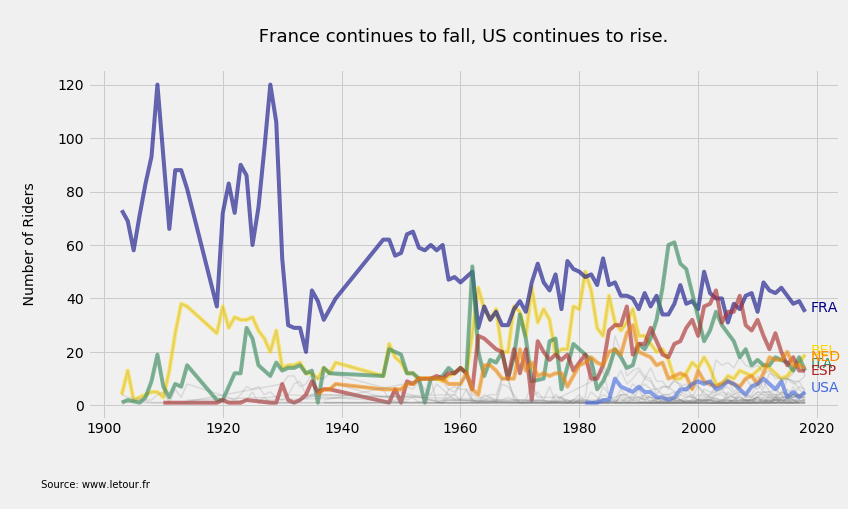

In [61]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
# plt.gcf().subplots_adjust(top=0.9, bottom=0.10, left=0.15, right=0.70)

# years = np.array(pivoted_df.columns)
# countries = np.array(pivoted_df.loc[co_list].sort_values(2018, ascending=False))


data = yr_nat_cnt.copy()

for country in list(data.country.unique()):
    d = data[data.country == country]
    
    if country == 'france':
        ax.plot(d.year, d.num_of_riders, color='darkblue', alpha=0.6)
        ax.text(d.year.tail(1)+1, d.num_of_riders.tail(1), d.ioc_code.tail(1).values[0].upper(), color='darkblue')
    if country == 'belgium':
        ax.plot(d.year, d.num_of_riders, color='gold', alpha=0.6)
        ax.text(d.year.tail(1)+1, d.num_of_riders.tail(1), d.ioc_code.tail(1).values[0].upper(), color='gold')
    if country == 'netherlands':
        ax.plot(d.year, d.num_of_riders, color='darkorange', alpha=0.6)
        ax.text(d.year.tail(1)+1, d.num_of_riders.tail(1)+2.5, d.ioc_code.tail(1).values[0].upper(), color='darkorange')
    if country == 'italy':
        ax.plot(d.year, d.num_of_riders, color='seagreen', alpha=0.6)
        ax.text(d.year.tail(1)+1, d.num_of_riders.tail(1)+1, d.ioc_code.tail(1).values[0].upper(), color='seagreen')
    if country == 'spain':
        ax.plot(d.year, d.num_of_riders, color='firebrick', alpha=0.6)
        ax.text(d.year.tail(1)+1, d.num_of_riders.tail(1)-1.5, d.ioc_code.tail(1).values[0].upper(), color='firebrick')
    if country == 'united states':
        ax.plot(d.year, d.num_of_riders, color='royalblue', alpha=0.6)
        ax.text(d.year.tail(1)+1, d.num_of_riders.tail(1), d.ioc_code.tail(1).values[0].upper(), color='royalblue')
    else:
        ax.plot(d.year, d.num_of_riders, color='grey', alpha=0.2, linewidth=1.5)
    
ax.set_title('\n France continues to fall, US continues to rise. \n', size=18)
# ax.set_xlim([1946, 2020])
# ax.set_ylim([0,69])
ax.set_ylabel('\n Number of Riders \n', size=14)
# ax.set_yticks([1,25,50,75,100,125,150,175])
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-50, -50), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/08_country_counts_over_time.png')

#### Zoom in on European countries (outside of the top 4)

In [62]:
euros = merged_df.copy()
euros = euros[euros.continent == 'europe']
# euros = euros[euros.country.isin(['france','belgium','italy','spain','netherlands']) == False] ## outside of top 5 countries
euros = euros[euros.country.isin(['france','belgium','italy','spain']) == False] 
print(euros.shape)
euros.head()

(3215, 8)


year      team  rider_num          rider_name nationality ioc_code  \
0  2018  TEAM SKY          1        CHRIS FROOME         gbr      gbr   
3  2018  TEAM SKY          4  MICHAL KWIATKOWSKI         pol      pol   
5  2018  TEAM SKY          6          WOUT POELS         ned      ned   
6  2018  TEAM SKY          7           LUKE ROWE         gbr      gbr   
7  2018  TEAM SKY          8      GERAINT THOMAS         gbr      gbr   

         country continent  
0  great britain    europe  
3         poland    europe  
5    netherlands    europe  
6  great britain    europe  
7  great britain    europe

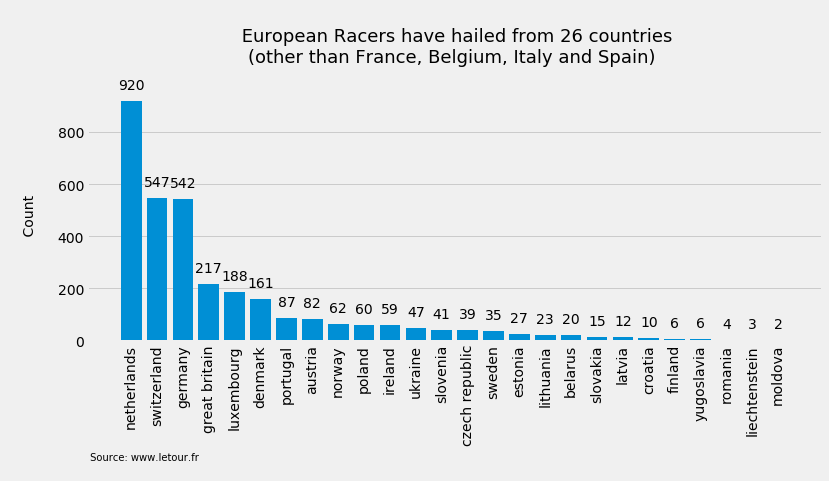

In [63]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8)

data = euros.country.value_counts(ascending=False)
    
ax.bar(data.index, data.values)
ax.set_title("\n European Racers have hailed from 26 countries\n(other than France, Belgium, Italy and Spain) \n", size=18)
ax.set_xticklabels(data.index, rotation=90)

for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, xytext=(0, 16),
                 textcoords='offset points')
    
plt.ylabel('\n Count \n', size=14)
ax.set_xticklabels(data.index)
ax.grid(b=False, axis='x')
plt.annotate('\n Source: www.letour.fr \n', (0,0), (0, -100), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.subplots_adjust(bottom=0.3, left=0.1)
plt.savefig(os.getcwd() + '/img/05_euro_riders.png')

#### How about non-European countries in particular?

In [64]:
noneuros = merged_df.copy()
noneuros = noneuros[noneuros.continent != 'europe']
noneuros.head()

year                                             team  rider_num  \
1   2018                                         TEAM SKY          2   
8   2018  TEAM EF EDUCATION FIRST - DRAPAC P/B CANNONDALE         11   
9   2018  TEAM EF EDUCATION FIRST - DRAPAC P/B CANNONDALE         12   
10  2018  TEAM EF EDUCATION FIRST - DRAPAC P/B CANNONDALE         13   
11  2018  TEAM EF EDUCATION FIRST - DRAPAC P/B CANNONDALE         14   

                       rider_name nationality ioc_code        country  \
1         EGAN ARLEY BERNAL GOMEZ         col      col       colombia   
8                  RIGOBERTO URAN         col      col       colombia   
9                    SIMON CLARKE         aus      aus      australia   
10                LAWSON CRADDOCK         usa      usa  united states   
11  DANIEL FELIPE MARTINEZ POVEDA         col      col       colombia   

        continent  
1   south america  
8   south america  
9         oceania  
10  north america  
11  south america

In [65]:
def set_continent_colors(x):
    if x == 'africa':
        return 'deepskyblue'
    if x == 'asia':
        return 'royalblue'
    if x == 'north america':
        return 'firebrick'
    if x == 'oceania':
        return 'grey'
    if x == 'south america':
        return 'salmon'

In [66]:
noneuros['continent_colors'] = noneuros.continent.apply(set_continent_colors)
noneuros.head(1)

year      team  rider_num               rider_name nationality ioc_code  \
1  2018  TEAM SKY          2  EGAN ARLEY BERNAL GOMEZ         col      col   

    country      continent continent_colors  
1  colombia  south america           salmon

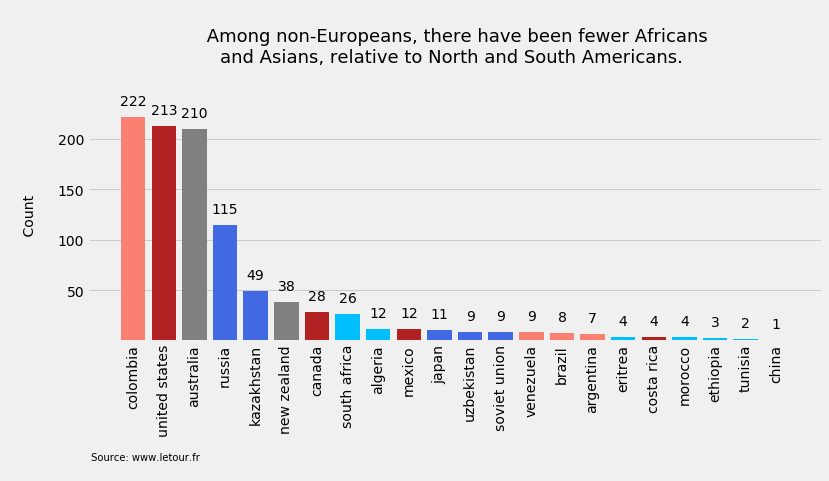

In [69]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8)

data = noneuros.groupby(['country','continent_colors']).size().sort_values(ascending=False).reset_index()
data.columns = ['country','continent_colors','num_of_riders']

bars = ax.bar(data.country, data.num_of_riders.values, color=data.continent_colors.values)
ax.set_title("\n Among non-Europeans, there have been fewer Africans\nand Asians, relative to North and South Americans. \n", size=18)
ax.set_xticklabels(data.index, rotation=90)

for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, xytext=(0, 16),
                 textcoords='offset points')
    
plt.ylabel('\n Count \n', size=14)
ax.set_xticklabels(data.country.values)
ax.set_ylim([0,250])
ax.set_yticks([50, 100, 150, 200])
ax.grid(b=False, axis='x')
plt.annotate('\n Source: www.letour.fr \n', (0,0), (0, -100), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.subplots_adjust(bottom=0.3, left=0.1)
plt.savefig(os.getcwd() + '/img/06_noneuro_riders.png')

### Visualizing dropouts

In [70]:
rankings_df = load_pickle('rankings_itg_all')
print(rankings_df.shape)
rankings_df.head()

(86033, 10)


year  stage_num  ranking                    rider  rider_no  \
0  2018          1        1  FERNANDO GAVIRIA RENDON       103   
1  2018          1        2              PETER SAGAN       111   
2  2018          1        3            MARCEL KITTEL       144   
3  2018          1        4            OLIVER NAESEN        27   
4  2018          1        5       ALEXANDER KRISTOFF        95   

                   team         times             gap    b    p  
0   QUICK - STEP FLOORS  04h 23' 22''               -  10'  NaN  
1      BORA - HANSGROHE  04h 23' 26''  + 00h 00' 04''  06'  NaN  
2  TEAM KATUSHA ALPECIN  04h 23' 28''  + 00h 00' 06''  04'  NaN  
3      AG2R LA MONDIALE  04h 23' 31''  + 00h 00' 09''  01'  NaN  
4     UAE TEAM EMIRATES  04h 23' 32''  + 00h 00' 10''  NaN  NaN

Calculate the number of riders at the **finish** of each year

In [71]:
num_finishers = rankings_df.groupby(['year','stage_num']).size().reset_index()
num_finishers.columns = ['year','stage_num','num_of_finishers']
gb = num_finishers.groupby('year')
num_finishers = gb.apply(lambda g: g[g['stage_num'] == g['stage_num'].max()]).reset_index(drop=True)
num_finishers.columns = ['year','stage_num','num_riders_at_finish']
num_finishers

year  stage_num  num_riders_at_finish
0    1903          6                    21
1    1904          6                    15
2    1905         11                    24
3    1906         12                     3
4    1907         14                    33
5    1908         13                     3
6    1909         14                    54
7    1910         15                    41
8    1911         15                    28
9    1912         15                    41
10   1913         15                    25
11   1914         15                    53
12   1919         15                    10
13   1920         15                    22
14   1921         15                    37
15   1922         15                    38
16   1923         15                    29
17   1924         15                    60
18   1925         18                    49
19   1926         17                    40
20   1927         24                    39
21   1928         22                    40
22   1929         22                    59
23   1930         21                    58
24   1931         24                    35
25   1932         21                    57
26   1933         23                    40
27   1934         23                    39
28   1935         21                    46
29   1936         21                    43
..    ...        ...                   ...
75   1989         21                   135
76   1990         21                   156
77   1991         22                   156
78   1992         21                   130
79   1993         20                   135
80   1994         21                   116
81   1995         20                   114
82   1996         21                   129
83   1997         21                   139
84   1998         21                    96
85   1999         20                   140
86   2000         21                   127
87   2001         20                   143
88   2002         20                   151
89   2003         20                   146
90   2004         20                   143
91   2005         21                   152
92   2006         20                   135
93   2007         20                   140
94   2008         21                   144
95   2009         21                   151
96   2010         20                   166
97   2011         21                   165
98   2012         20                   151
99   2013         21                   169
100  2014         21                   164
101  2015         21                   160
102  2016         21                   174
103  2017         21                   167
104  2018         21                   145

[105 rows x 3 columns]

Calculate number of riders at the **start** of each year

In [72]:
starters_df.head()

year      team  rider_num               rider_name nationality
0  2018  TEAM SKY          1             CHRIS FROOME         gbr
1  2018  TEAM SKY          2  EGAN ARLEY BERNAL GOMEZ         col
2  2018  TEAM SKY          3     JONATHAN CASTROVIEJO         esp
3  2018  TEAM SKY          4       MICHAL KWIATKOWSKI         pol
4  2018  TEAM SKY          5            GIANNI MOSCON         ita

In [73]:
num_starters = starters_df.groupby('year').size().reset_index()
num_starters.columns = ['year','num_riders_at_start']
num_starters

year  num_riders_at_start
0    1903                   84
1    1904                   88
2    1905                   60
3    1906                   78
4    1907                   93
5    1908                  111
6    1909                  150
7    1910                  110
8    1911                   84
9    1912                  131
10   1913                  140
11   1914                  145
12   1919                   67
13   1920                  113
14   1921                  123
15   1922                  120
16   1923                  139
17   1924                  158
18   1925                  129
19   1926                  126
20   1927                  142
21   1928                  162
22   1929                  155
23   1930                  100
24   1931                   81
25   1932                   80
26   1933                   80
27   1934                   60
28   1935                   93
29   1936                   90
..    ...                  ...
75   1989                  198
76   1990                  198
77   1991                  198
78   1992                  198
79   1993                  180
80   1994                  189
81   1995                  189
82   1996                  198
83   1997                  198
84   1998                  189
85   1999                  180
86   2000                  180
87   2001                  189
88   2002                  189
89   2003                  198
90   2004                  188
91   2005                  189
92   2006                  176
93   2007                  189
94   2008                  180
95   2009                  180
96   2010                  198
97   2011                  198
98   2012                  198
99   2013                  198
100  2014                  198
101  2015                  198
102  2016                  198
103  2017                  198
104  2018                  176

[105 rows x 2 columns]

Merge together

In [74]:
print(num_finishers.shape)
num_starters.shape

(105, 3)


(105, 2)

In [75]:
dropouts = pd.merge(num_finishers, num_starters, how='left',on='year')
print(dropouts.shape)
dropouts.head()

(105, 4)


year  stage_num  num_riders_at_finish  num_riders_at_start
0  1903          6                    21                   84
1  1904          6                    15                   88
2  1905         11                    24                   60
3  1906         12                     3                   78
4  1907         14                    33                   93

In [76]:
dropouts['dropouts'] = dropouts.num_riders_at_start - dropouts.num_riders_at_finish
dropouts

year  stage_num  num_riders_at_finish  num_riders_at_start  dropouts
0    1903          6                    21                   84        63
1    1904          6                    15                   88        73
2    1905         11                    24                   60        36
3    1906         12                     3                   78        75
4    1907         14                    33                   93        60
5    1908         13                     3                  111       108
6    1909         14                    54                  150        96
7    1910         15                    41                  110        69
8    1911         15                    28                   84        56
9    1912         15                    41                  131        90
10   1913         15                    25                  140       115
11   1914         15                    53                  145        92
12   1919         15                    10                   67        57
13   1920         15                    22                  113        91
14   1921         15                    37                  123        86
15   1922         15                    38                  120        82
16   1923         15                    29                  139       110
17   1924         15                    60                  158        98
18   1925         18                    49                  129        80
19   1926         17                    40                  126        86
20   1927         24                    39                  142       103
21   1928         22                    40                  162       122
22   1929         22                    59                  155        96
23   1930         21                    58                  100        42
24   1931         24                    35                   81        46
25   1932         21                    57                   80        23
26   1933         23                    40                   80        40
27   1934         23                    39                   60        21
28   1935         21                    46                   93        47
29   1936         21                    43                   90        47
..    ...        ...                   ...                  ...       ...
75   1989         21                   135                  198        63
76   1990         21                   156                  198        42
77   1991         22                   156                  198        42
78   1992         21                   130                  198        68
79   1993         20                   135                  180        45
80   1994         21                   116                  189        73
81   1995         20                   114                  189        75
82   1996         21                   129                  198        69
83   1997         21                   139                  198        59
84   1998         21                    96                  189        93
85   1999         20                   140                  180        40
86   2000         21                   127                  180        53
87   2001         20                   143                  189        46
88   2002         20                   151                  189        38
89   2003         20                   146                  198        52
90   2004         20                   143                  188        45
91   2005         21                   152                  189        37
92   2006         20                   135                  176        41
93   2007         20                   140                  189        49
94   2008         21                   144                  180        36
95   2009         21                   151                  180        29
96   2010         20                   166                  198        32
97   2011

Text(0, -60, '\n Source: www.letour.fr \n')

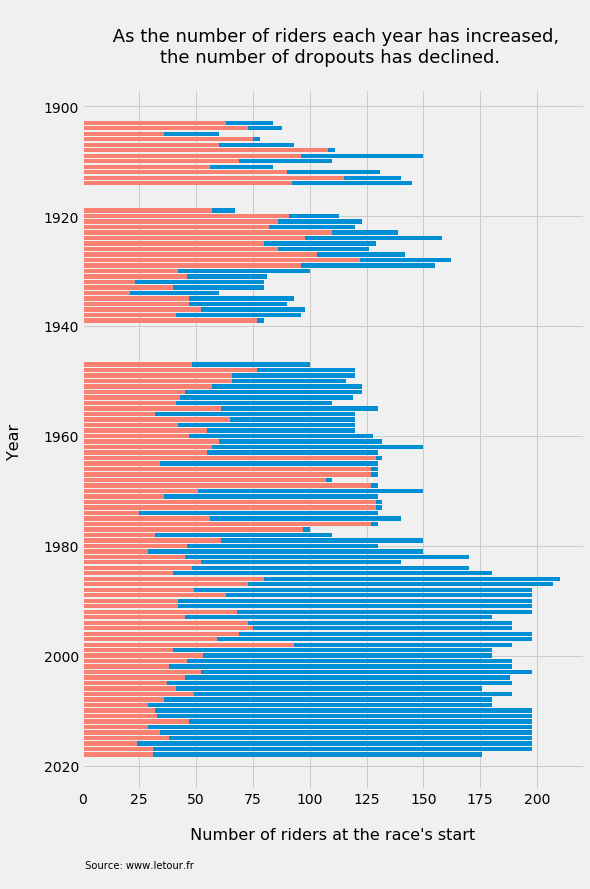

In [124]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
# plt.gcf().subplots_adjust(top=0.85, bottom=0.15)

data = dropouts.copy()

ax.barh(data.year, data.dropouts, color='salmon')
ax.barh(data.year, data.num_riders_at_finish, left=data.dropouts)

ax.set_title("\n As the number of riders each year has increased,\nthe number of dropouts has declined. \n", size=18)
# ax.set_xlim(0,145)
plt.xlabel("\n Number of riders at the race's start \n", size=16)
plt.ylabel('Year \n', size=16)
plt.gca().invert_yaxis()
plt.annotate('\n Source: www.letour.fr \n', (0,0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
# plt.savefig(os.getcwd() + '/img/00_num_stages_over_time.png')

### Building a Chord Chart for city links

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
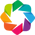

In [88]:
import holoviews as hv
from holoviews import opts, dim
# from bokeh.io import export_png

hv.extension('bokeh')
hv.output(size=200)

In [79]:
stages_df = load_pickle('stages_all')
print(stages_df.shape)
stages_df.head()

(2259, 5)


year stage_num date_start                start_city        finish_city
0  2018   Stage 1 2018-07-07      Noirmoutier-en-l'Île  Fontenay-le-Comte
1  2018   Stage 2 2018-08-07  Mouilleron-Saint-Germain   La Roche-sur-Yon
2  2018   Stage 3 2018-09-07                    Cholet             Cholet
3  2018   Stage 4 2018-10-07                  La Baule            Sarzeau
4  2018   Stage 5 2018-11-07                   Lorient            Quimper

#### Construct the `links` data

In [80]:
stages_df

year   stage_num date_start                    start_city  \
0     2018     Stage 1 2018-07-07          Noirmoutier-en-l'Île   
1     2018     Stage 2 2018-08-07      Mouilleron-Saint-Germain   
2     2018     Stage 3 2018-09-07                        Cholet   
3     2018     Stage 4 2018-10-07                      La Baule   
4     2018     Stage 5 2018-11-07                       Lorient   
5     2018     Stage 6 2018-12-07                         Brest   
6     2018     Stage 7 2018-07-13                      Fougères   
7     2018     Stage 8 2018-07-14                         Dreux   
8     2018     Stage 9 2018-07-15               Arras Citadelle   
9     2018    Stage 10 2018-07-17                        Annecy   
10    2018    Stage 11 2018-07-18                   Albertville   
11    2018    Stage 12 2018-07-19  Bourg-Saint-Maurice Les Arcs   
12    2018    Stage 13 2018-07-20                Bourg d'Oisans   
13    2018    Stage 14 2018-07-21     Saint-Paul-Trois-Châteaux   
14    2018    Stage 15 2018-07-22                        Millau   
15    2018    Stage 16 2018-07-24                   Carcassonne   
16    2018    Stage 17 2018-07-25            Bagnères-de-Luchon   
17    2018    Stage 18 2018-07-26                Trie-sur-Baïse   
18    2018    Stage 19 2018-07-27                       Lourdes   
19    2018    Stage 20 2018-07-28         Saint-Pée-sur-Nivelle   
20    2018    Stage 21 2018-07-29                      Houilles   
21    2017     Stage 1 2017-01-07                    Düsseldorf   
22    2017     Stage 2 2017-02-07                    Düsseldorf   
23    2017     Stage 3 2017-03-07                      Verviers   
24    2017     Stage 4 2017-04-07             Mondorf-les-Bains   
25    2017     Stage 5 2017-05-07                        Vittel   
26    2017     Stage 6 2017-06-07                        Vesoul   
27    2017     Stage 7 2017-07-07                        Troyes   
28    2017     Stage 8 2017-08-07                          Dôle   
29    2017     Stage 9 2017-09-07                        Nantua   
...    ...         ...        ...                           ...   
2229  1906     Stage 8 1906-07-18                      Toulouse   
2230  1906     Stage 9 1906-07-20                       Bayonne   
2231  1906    Stage 10 1906-07-22                      Bordeaux   
2232  1906    Stage 11 1906-07-24                        Nantes   
2233  1906    Stage 12 1906-07-26                         Brest   
2234  1906  Stage 13.1 1906-07-29                          Caen   
2235  1906  Stage 13.2 1906-07-29                          Caen   
2236  1905     Stage 1 1905-09-07                         Paris   
2237  1905     Stage 2 1905-11-07                         Nancy   
2238  1905     Stage 3 1905-07-14                      Besançon   
2239  1905     Stage 4 1905-07-16                      Grenoble   
2240  1905     Stage 5 1905-07-18                        Toulon   
2241  1905     Stage 6 1905-07-20                         Nimes   
2242  1905     Stage 7 1905-07-23                      Toulouse   
2243  1905     Stage 8 1905-07-25                      Bordeaux   
2244  1905     Stage 9 1905-07-27                   La Rochelle   
2245  1905    Stage 10 1905-07-29                        Rennes   
2246  1905    Stage 11 1905-07-30                          Caen   
2247  1904     Stage 1 1904-02-07                         Paris   
2248  1904     Stage 2 1904-09-07                          Lyon   
2249  1904     Stage 3 1904-07-13                     Marseille   
2250  1904     Stage 4 1904-07-17                      Toulouse   
2251  1904     Stage 5 1904-07-20                      Bordeaux   
2252  1904     Stage 6 1904-07-23                 Ville d'Avray   
2253  1903     Stage 1 1903-01-07                         Paris   
2254  1903     Stage 2 1903-04-07                          Lyon   
2255  1903     Stage 3 1903-08-07                     Marseille   
2256  1903     Stage 4 1903-12-07                    

In [81]:
s = stages_df.copy()
s = s[['start_city','finish_city']]
s = s.groupby(['start_city','finish_city']).size().sort_values(ascending=False).reset_index()
s.columns = ['start_city','finish_city','value']
s = s[s.value > 4] # focus on cities w/ at least 5 starts or finishes
print(s.shape)
s.head()

(62, 3)


start_city finish_city  value
0         Pau    Bordeaux     18
1      Luchon   Perpignan     17
2         Pau      Luchon     14
3        Caen       Paris     14
4  Strasbourg        Metz     13

In [82]:
paris_first_list = list(s.start_city.unique())
paris_first_list.insert(0, paris_first_list.pop(11))  # paris is at position 11

In [83]:
city_mapping = dict(zip(paris_first_list,np.arange(0,len(paris_first_list))))
city_mapping['Toulouse'] = len(paris_first_list)
city_mapping['Malo'] = len(paris_first_list) + 1
# city_mapping['Paris'] = 0
# city_mapping['Pau'] = 11
s['source'] = s.start_city.map(city_mapping) 
s['target'] = s.finish_city.map(city_mapping) 
s.head(20)

start_city            finish_city  value  source  target
0                     Pau               Bordeaux     18       1       5
1                  Luchon              Perpignan     17       2      27
2                     Pau                 Luchon     14       1       2
3                    Caen                  Paris     14       3       0
4              Strasbourg                   Metz     13       4      11
5                Bordeaux                Bayonne     12       5       6
6                 Bayonne                 Luchon     12       6       2
7               Dunkerque                  Paris     10       7       0
8   Cherbourg-en-Cotentin                  Brest     10       8      14
9              Versailles                  Paris     10       9       0
10                Bayonne                    Pau     10       6       1
11               Le Havre  Cherbourg-en-Cotentin     10      10       8
12                   Metz                Belfort      9      11      35
13                 Luchon                    Pau      9       2       1
14                  Paris               Le Havre      9       0      10
15                   Nice               Grenoble      8      12      18
16               Briançon          Aix-les-Bains      8      13      34
17                   Metz              Dunkerque      8      11       7
18                  Paris                   Caen      8       0       3
19                  Brest             Les Sables      7      14      20

In [84]:
links_tdf = s.copy()
links_tdf = links_tdf.sort_values(['source','target']).reset_index(drop=True)
links_tdf = links_tdf[['source','target','value']]
links_tdf

source  target  value
0        0       3      8
1        0      10      9
2        0      37      7
3        1       2     14
4        1       5     18
5        2       1      9
6        2      27     17
7        2      40      6
8        3       0     14
9        4      11     13
10       5       1      5
11       5       5      5
12       5       6     12
13       5      33      7
14       6       1     10
15       6       2     12
16       6       5      6
17       7       0     10
18       8      14     10
19       9       0     10
20      10       8     10
21      11       7      8
22      11      35      9
23      11      36      6
24      12      13      6
25      12      18      8
26      13      21      6
27      13      34      8
28      14       3      5
29      14      20      7
..     ...     ...    ...
32      15      27      5
33      16      12      7
34      17       5      7
35      18      12      7
36      19      13      7
37      20       5      7
38      20       6      6
39      21      12      6
40      22       5      6
41      23      23      6
42      24      20      6
43      25      18      6
44      26      15      5
45      26      39      6
46      27       2      5
47      27      16      5
48      27      26      5
49      28      28      5
50      29      18      5
51      30       0      5
52      31      14      5
53      32       1      5
54      33      14      5
55      34      18      5
56      35       4      5
57      36      11      5
58      36      41      5
59      37      36      5
60      38      38      5
61      39      26      5

[62 rows x 3 columns]

#### Top cities hosting stages overall

In [98]:
# paris
links_tdf[(links_tdf.source == 0) | (links_tdf.target == 0)]['value'].sum()

63

In [115]:
df_base = pd.DataFrame({'city':list(city_mapping.keys()),
              'idx':list(city_mapping.values())})

In [122]:
df1 = links_tdf.groupby('source')['value'].sum().reset_index()
df2 = links_tdf.groupby('target')['value'].sum().reset_index()
df = pd.merge(df1, df2, left_on='source', right_on='target')
df = pd.merge(df, df_base, left_on='source', right_on='idx')
df['total_stages'] = df.value_x + df.value_y
df[['city','idx','total_stages']].sort_values('total_stages', ascending=False).head(10)

city  idx  total_stages
5    Bordeaux    5            78
0       Paris    0            63
2      Luchon    2            63
1         Pau    1            61
6     Bayonne    6            46
10       Metz   11            41
13      Brest   14            39
22  Perpignan   27            37
11       Nice   12            34
16   Grenoble   18            31

#### Construct the `nodes` data

In [85]:
nodes_tdf = pd.DataFrame({'city':list(city_mapping.keys())}, index=city_mapping.values())
nodes_tdf = hv.Dataset(nodes_tdf, 'index')
nodes_tdf.data.head()

index        city
0      0       Paris
1      1         Pau
2      2      Luchon
3      3        Caen
4      4  Strasbourg

#### Plot a chord chart!

In [123]:
chord = hv.Chord((links_tdf
                  , nodes_tdf))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='city', node_color=dim('index').str()))

:Chord   [source,target]   (value)

In [123]:
renderer = hv.renderer('bokeh')

renderer.save(chord, 'img/chord')